# <font color=green>deepBreaks Applications</font>
## Modeling spectral tuning sites of opsin proteins based on amino-acid sequence...  

In [ ]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_simp_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
from deepBreaks.preprocessing import write_fasta
import numpy as np
import csv
import pandas as pd
import warnings
import datetime
import os
import shutil
import time

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')


In [ ]:
# defining user params, file pathes, analysis type

#assign your path to folder containing all the datasplits
path = './vizphiz_data_splits_2024-05-02_16-58-09'
# path to sequences of interest
seqFileName = f'{path}/vert_aligned_VPOD_1.1_het.fasta' 
# path to corresponding metadata of interest
metaDataFileName = f'{path}/vert_meta.tsv' 

# name of the phenotype
mt = 'Lambda_Max'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'reg' 

gap_threshold = 0.6

keep_wt = False

In [ ]:
print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
metaFile = metaDataFileName.split('/')[1]
# importing sequences data
print('reading fasta file')
ref_df = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)
#merging in lambda max values, simultaneously dropping all sequences without entries in metadata file
#ref_df= ref_df.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
ref_df = read_data(metaDataFileName, seq_type = None, is_main=False)
if keep_wt == False:
    ref_df = ref_df[
    (ref_df['Mutations'].notna()) |  # Keep rows where Mutations is NOT empty
    (ref_df['Accession'].str.contains('-'))# AND NOT containing '_( in Accession
    ]
    ref_df = ref_df[~ref_df['Accession'].astype(str).str.contains('_\(')]
#tr.shape
test_iter = 0
first_run = 0
umd = []
predictions_list = []

In [ ]:
import scipy.stats as st
# Perform paired t-test
t_statistic, p_value = st.ttest_rel(wds_test['Difference'], wt_test['Difference'])

print("Paired t-test: t-statistic =", t_statistic, "p-value =", p_value)


In [ ]:
while ref_df.shape[0]>0:
    tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)
    #merging in lambda max values, simultaneously dropping all sequences without entries in metadata file
    tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
    #tr.shape
    # making a unique directory for saving the reports of the analysis
    print('direcory preparation')
    dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    seqFile = seqFileName.split('/')[2]
    #print(seqFile)
    seqFile = seqFile.split('.')[0]
    #print(seqFile)
    report_dir = str(seqFile +'_' + mt + '_' + dt_label)
    os.makedirs(report_dir)

    #creating a copy of the input fasta file and metadata file into the report directory
    shutil.copy2(f'{seqFileName}' , report_dir)
    shutil.copy2(f'{metaDataFileName}' , report_dir)

    #changing the number of test sequences to extract from the training dataframe based on the size of the training dataset
    if tr.shape[0] <= 150:
        sample_n = 15
    elif tr.shape[0] > 150 and tr.shape[0] <= 300:
        sample_n = 25
    elif tr.shape[0] > 300 and tr.shape[0] <= 1000:
        sample_n = 25
    else:
        sample_n = 25

    n=0
    while n<1:
        try:
            drop_indices = np.random.choice(ref_df.index, sample_n, replace=False)
            #print(drop_indices)
            #copying the sampled indices into a seperate dataframe to act as our 'unseen' test data later
            unseen = tr.loc[drop_indices].copy()
            umd.extend(unseen.loc[:, mt].values)
            #dropping our sample indices from the training dataframe
            unseen.drop(mt, axis=1, inplace=True)
            ref_df = ref_df.drop(drop_indices)
            n+=1
        except:
            sample_n = ref_df.shape[0]

    if first_run == 0:
        base_test = meta_data.loc[drop_indices].copy()
        first_run+=1
    else:
        # Use the loc method to add the new row to the DataFrame
        base_test = base_test.append(meta_data.loc[drop_indices].copy())
        print(f'Length of Base_Test DF: {len(base_test)}')

    tr = tr.drop(drop_indices)
    y = tr.loc[:, mt].values
    tr.drop(mt, axis=1, inplace=True)

    #settingthe paramaters for our ML pipeline
    prep_pipeline = make_pipeline(
        steps=[
            ('mc', MisCare(missing_threshold=0.05)),
            ('cc', ConstantCare()),
            ('ur', URareCare(threshold=0.025)),
            ('cc2', ConstantCare()),
            ('one_hot', CustomOneHotEncoder()),
            ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=False)),
            ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.03, keep=False))
        ])

    #training models
    report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                                models_dict=get_models(ana_type=ana_type),
                                scoring=get_scores(ana_type=ana_type),
                                report_dir=report_dir,
                                cv=12, ana_type=ana_type, cache_dir=report_dir)

                                
    time.sleep(1)
    #setting parameters for tuning the top 3 performing models
    prep_pipeline = make_pipeline(
        steps=[
            ('mc', MisCare(missing_threshold=0.05)),
            ('cc', ConstantCare()),
            ('ur', URareCare(threshold=0.025)),
            ('cc2', ConstantCare()),
            ('one_hot', CustomOneHotEncoder()),
            ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=True)),
            ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.03, keep=True))
        ])

    modified_top = []
    mtml = []
    for model in top:
        modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))
        my_top_models = str(model[1:])
        #print(my_top_models)
        my_top_models = my_top_models.split("'")[3]
        mtml.append(my_top_models)
        #print(my_top_models)

    #print(mtml)
    time.sleep(1)

    #tuning the top 3 performing models 
    top = finalize_top(X=tr, y=y, top_models=modified_top, grid_param=get_simp_params(),report_dir=report_dir, cv=10)
    #summarize the results by extracting feature importance and p-values and grouping correlated features.
    sr = summarize_results(top_models=top, report_dir=report_dir)
    #plot a scatter plot with -log of (p-value) column as the x-axis and the values of the other columns 
    scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

    time.sleep(1)

    #plot mean relative importance of each feature - corresponding to an amino acid position.
    mean_imp = mean_importance(top, report_dir=report_dir)

    dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)
    tr = prep_pipeline[:4].fit_transform(tr)

    for model in top:
        model_name = model.steps[-1][0]
        dp_plot(importance=importance_from_pipe(model),
                imp_col='standard_value',
                model_name = model_name, report_dir=report_dir)
        
        plot_imp_model(importance=importance_from_pipe(model), 
                X_train=tr, y_train=y, model_name=model_name,
                    meta_var='meta', model_type=ana_type, report_dir=report_dir)

    time.sleep(1)
                    

    from deepBreaks.utils import load_obj
    import joblib
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_absolute_percentage_error
    from sklearn.metrics import mean_squared_error

    plt.show()
    plt.clf()

    #load and test the top performing linear regression model.
    try:
        top_per_mod = report_dir + '/gbc.pkl'
        load_rf = load_obj(top_per_mod)
    except:
        top_per_mod = report_dir + '/' + mtml[0] + '.pkl'
        load_rf = load_obj(top_per_mod)
    time.sleep(3)
    predictions = load_rf.predict(unseen)
    predictions_list.extend(predictions)
    print(f'Length of Precictions List: {len(base_test)}')

    #print(predictions)
   

In [ ]:
from scipy import stats
import re
import joblib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from deepBreaks.preprocessing import read_data

In [ ]:

# Function to get prediction interval for a linear regression
def get_prediction_interval(prediction, y_test, test_predictions, pi=0.95):
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper


In [ ]:
wt_metadata = "wt_meta.tsv"
wt_meta = pd.read_csv(wt_metadata, sep="\t", index_col = 0)


In [95]:
base_test['Prediction'] = predictions_list
base_test['Difference'] = base_test['Lambda_Max'] - base_test['Prediction']

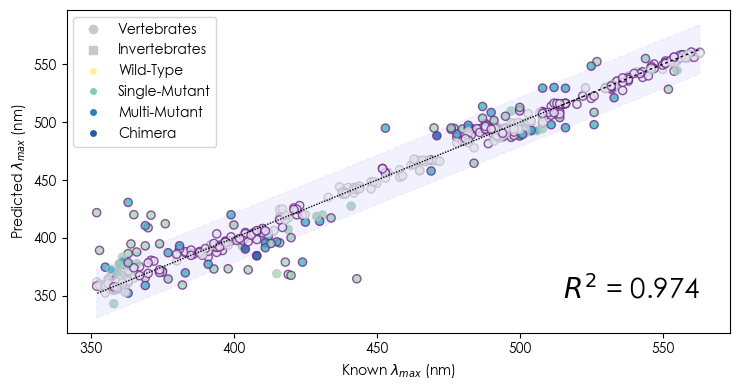

<Figure size 750x400 with 0 Axes>

0.9742158402355001


In [96]:
test = 'vert'
mut_type = []
edgecolors = []
colors = []
wt_acc_list = []
wt_lmax = []
mut_diff = []
for ind in base_test.index:
    if abs(base_test['Difference'][ind]) >= 10:
        #edgecolors.append('k')
        if '-' in str(base_test['Accession'][ind]):
            #dark blue - chimeras
            colors.append('#225ea8')
            mut_type.append('Chimera')
        elif str(base_test['Mutations'][ind]).count('_') >= 1 or str(base_test['Mutations'][ind]).count(',') >= 1:
            #green-blue - one mutation
            colors.append('#41b6c4')
            mut_type.append('Multiple Mutations')
        elif str(base_test['Mutations'][ind]) != 'nan' and str(base_test['Mutations'][ind]).count('_') == 0 and str(base_test['Mutations'][ind]).count(',') == 0:
            #green-blue - one mutation
            colors.append('#a1dab4')
            mut_type.append('Single Mutation')
        else:
            #light-yellow - Wild-Type
            colors.append('#ffffb2')
            mut_type.append('Wild-Type')
    else:
        colors.append('#f0f0f0')
        #edgecolors.append('#c9c9c9')
        if '-' in str(base_test['Accession'][ind]):
            mut_type.append('Chimera')
        elif str(base_test['Mutations'][ind]).count('_') >= 1 or str(base_test['Mutations'][ind]).count(',') >= 1:
            mut_type.append('Multiple Mutations')
        elif str(base_test['Mutations'][ind]) != 'nan' and str(base_test['Mutations'][ind]).count('_') == 0 and str(base_test['Mutations'][ind]).count(',') == 0:
            mut_type.append('Single Mutation')
        else:
            mut_type.append('Wild-Type')
            
            
    repeat_check = 0
    for wt in wt_meta.index:
        if repeat_check < 1:
            acc = wt_meta['Accession'][wt]
            acc = acc.split('.')[0]
            wt_acc = re.compile(f"^{acc}")

            if wt_acc.match(base_test['Accession'][ind]):
                if abs(wt_meta['Lambda_Max'][wt]-base_test['Lambda_Max'][ind]) >= 10:
                    edgecolors.append('#762a83')
                else:
                    edgecolors.append('#c9c9c9')
                diff = abs(wt_meta['Lambda_Max'][wt]-base_test['Lambda_Max'][ind])
                mut_diff.append(diff)
                wt_acc_list.append(wt_meta['Accession'][wt])
                wt_lmax.append(wt_meta['Lambda_Max'][wt])

                repeat_check += 1
            else:
                pass
        else:
            pass
    if repeat_check == 0:
        edgecolors.append('#c9c9c9')
        mut_diff.append('NA')
        wt_acc_list.append('No Match')
        wt_lmax.append('NA')
    else:
        pass

mut_wt_comp = pd.DataFrame()
mut_wt_comp["Mut_Acc"] = base_test["Accession"]
mut_wt_comp["WT_Acc"] = wt_acc_list
mut_wt_comp["Mut_Lmax"] = base_test["Lambda_Max"]
mut_wt_comp["WT_Lmax"] = wt_lmax
mut_wt_comp["Abs_Diff"] = mut_diff
mut_wt_comp["Edge_Colors"] = edgecolors
mut_wt_comp.to_csv(path_or_buf= f'{report_dir}/wt_mut_comp.csv',index_label=True,mode="w")

base_test['mutant_type'] = mut_type
#plotting the predicted vs. known lambda max values...

#Adding in out desired font - feel free to change. :)
plt.rcParams['font.family'] = 'Century Gothic'

plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 4.00]
#plt.title("$λ_{max}$ Predictions for Vertebrate Opsin Dataset")

# Create a new column 'Marker' based on 'Phylum'
true_lmax = base_test['Lambda_Max']
predictions = base_test['Prediction']
base_test['Marker'] = np.where(base_test['Phylum'] == 'Chordata', 'o', 's')
markers = base_test['Marker'].tolist()
mask_o = np.array(markers) == 'o'
mask_s = np.array(markers) == 's'
# Create two separate scatter plots for invertebrates and vertebrates
scatter1 = plt.scatter(true_lmax[mask_o], predictions[mask_o], c=np.array(colors)[mask_o], ec=np.array(edgecolors)[mask_o], edgecolors='k', s=35, alpha=0.8, marker='o', label='Vertebrates')
scatter2 = plt.scatter(true_lmax[mask_s], predictions[mask_s], c=np.array(colors)[mask_s], ec=np.array(edgecolors)[mask_s], edgecolors='k', s=35, alpha=0.8, marker='s', label='Invertebrates')


#plt.scatter(base_test['Lambda_Max'], base_test['Prediction'], c=colors, ec = edgecolors, edgecolors='k', s = 35)
plt.plot(base_test['Lambda_Max'], base_test['Lambda_Max'], c = 'k', linewidth = '1.0', ls = '--', dashes = (1,3))

# Confidence ribbon using prediction interval
# Sort data by 'Lambda_Max' for smoother ribbon
sorted_indices = np.argsort(base_test['Lambda_Max'])
sorted_lambda_max = base_test['Lambda_Max'].values[sorted_indices]
sorted_prediction = base_test['Prediction'].values[sorted_indices]
lower_vet = []
upper_vet = []
for i in sorted_lambda_max:
    lower, prediction, upper = get_prediction_interval(i, base_test['Lambda_Max'], base_test['Prediction'])
    lower_vet.append(lower)
    upper_vet.append(upper)

# Plotting the confidence ribbon directly using fill_between
plt.fill_between(sorted_lambda_max, lower_vet, upper_vet, color='blue', alpha=0.05, ls = '--')


plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#c9c9c9', markeredgecolor= '#c9c9c9', markersize=6),
                  plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#c9c9c9', markeredgecolor= '#c9c9c9', markersize=6),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#ffeda0', markersize=12),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#7fcdbb', markersize=12),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#2c7fb8', markersize=12),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#225ea8', markersize=12)]
legend_labels = ['Vertebrates', 'Invertebrates', 'Wild-Type','Single-Mutant', 'Multi-Mutant', 'Chimera']

# Adjust bbox_to_anchor values to place the legend inside the graph
plt.legend(handles=legend_handles, labels=legend_labels, loc='upper left')

#plot and adjust position of the R^2 value
plt.annotate(f"$R^2$ = {stats.linregress(base_test['Lambda_Max'],base_test['Prediction'])[2]**2:.3f}", (max(base_test['Lambda_Max']), min(base_test['Prediction'])), ha='right', va='bottom', fontsize=20, c='k')

#plt.xticks(range(min(umd), max(umd)+1))
fileout = f'{test}_iter_test_95ci.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = f'{test}_iter_test_95ci.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

base_test['Colors'] = colors
base_test['EdgeColors'] = edgecolors
base_test = base_test[['Species', 'Phylum', 'Opsin_Family', 'Accession', 'Mutations','Lambda_Max','Prediction','Difference','Colors','EdgeColors','mutant_type']]
#writing df to a csv file for secondary analysis in report directory
base_test.to_csv(path_or_buf= f'{test}_itr_test_results.csv',index = 'Feature',mode="w")

#calculating r^2, mae, mape, sqe, and rsque for the model on our subsample of extracted test data
model_testing__report = f'{report_dir}/model_testing report.tsv'
base_rsq = stats.linregress(base_test['Lambda_Max'],base_test['Prediction'])[2]**2
print(base_rsq)
base_mae = mean_absolute_error(base_test['Lambda_Max'],base_test['Prediction'])
#print(base_mae)
base_mape = mean_absolute_percentage_error(base_test['Lambda_Max'],base_test['Prediction'])
#print(base_mape)
base_sqe = mean_squared_error(base_test['Lambda_Max'],base_test['Prediction'])
#print(base_sqe)
base_rsqe = mean_squared_error(base_test['Lambda_Max'],base_test['Prediction'],squared = False)
#print(base_rsqe)
with open(model_testing__report , 'a') as f:
    f.write(f'Base Model R^2\tMAE\tMAPE\tSQE\tRSQE\n')
    f.write(f'{str(base_rsq)}\t{str(base_mae)}\t{str(base_mape)}\t{str(base_sqe)}\t{str(base_rsqe)}')

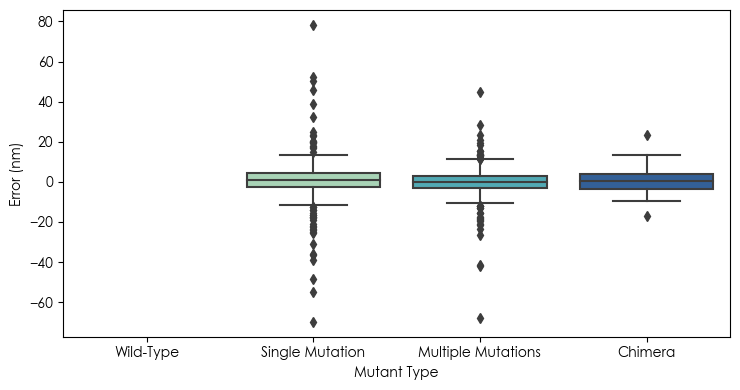

<Figure size 750x400 with 0 Axes>

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but it enhances the aesthetics of plots
import pandas as pd

plt.figure(figsize = [7.50, 4.00])
#palette = sns.color_palette("Set2")
palette = ['#ffffb2','#a1dab4','#41b6c4','#225ea8']

sns.boxplot(x='mutant_type', y='Difference', data=base_test, dodge=False, palette=palette, order = ['Wild-Type', 'Single Mutation', 'Multiple Mutations', 'Chimera'])
# Customize axis labels
plt.xlabel('Mutant Type')
plt.ylabel('Error (nm)')

#save file
fileout = 'wds_iter_test_err_bxplts.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'wds_iter_test_err_bxplts.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

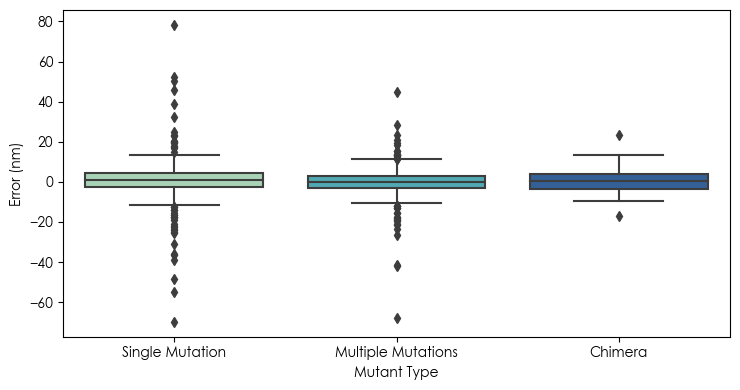

<Figure size 750x400 with 0 Axes>

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but it enhances the aesthetics of plots
import pandas as pd

plt.figure(figsize = [7.50, 4.00])
#palette = sns.color_palette("Set2")
palette = ['#a1dab4','#41b6c4','#225ea8']

sns.boxplot(x='mutant_type', y='Difference', data=base_test, dodge=False, palette=palette, order = ['Single Mutation', 'Multiple Mutations', 'Chimera'])
# Customize axis labels
plt.xlabel('Mutant Type')
plt.ylabel('Error (nm)')

#save file
fileout = 'wds_onlymuts_iter_test_err_bxplts.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'wds_onlymuts_iter_test_err_bxplts.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

In [ ]:

plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 4.00]
plt.title("$λ_{max}$ Predictions for Whole Opsin Dataset")
plt.scatter(base_test['Lambda_Max'],base_test['Prediction'], c='#d1e5f0', ec = 'black', edgecolors='k', s = 35)
plt.plot(umd, umd, c = 'k', linewidth = '1.0', ls = '--', dashes = (1,3))
plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')

plt.annotate(f"$R^2$ = {stats.linregress(base_test['Lambda_Max'],base_test['Prediction'])[2]**2:.3f}", (max(base_test['Lambda_Max']), min(base_test['Prediction'])), ha='right', va='bottom', fontsize=20, c='k')
#plt.xticks(range(min(umd), max(umd)+1))
fileout = f'{report_dir}/hetero_uniform.pdf'
plt.savefig(fileout)
fileout = f'{report_dir}/hetero_uniform.png'
plt.savefig(fileout)
plt.show()
plt.clf()